### Imports

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import loguniform, randint
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from wordcloud import WordCloud

### Training:

#### Load and visualize training data

In [3]:
data = pd.read_csv("../data/training/training-features.csv")
data.head()

,url,label,url_length,number_of_slashes,is_https,number_of_http_occurrences,number_of_https_occurrences,number_of_dots,is_ip,number_of_digits,...,ratio_of_special_chars,number_of_subdirectories,number_of_query_params,tld_length,has_fragment_identifier,has_credentials,is_known_shortening_service,domain_length,char_continuation_rate,suspicious_keywords
0,https://accounts.google.com/,1,28,3,1,0,1,2,0,0,...,0.214286,0,0,3,0,0,0,19,0.392857,1
1,https://bato.to/series/191514/god-s-peace-cupi...,1,71,5,1,0,1,1,0,6,...,0.183099,3,0,2,0,0,0,7,0.267606,0
2,https://bbs.ruliweb.com/,1,24,3,1,0,1,2,0,0,...,0.250000,0,0,3,0,0,0,15,0.416667,0
3,https://fr.m.wikipedia.org/,1,27,3,1,0,1,3,0,0,...,0.259259,0,0,3,0,0,0,18,0.444444,0
4,https://lichess.org/,1,20,3,1,0,1,1,0,0,...,0.250000,0,0,3,0,0,0,11,0.500000,0


In [4]:
data.columns

Index(['url', 'label', 'url_length', 'number_of_slashes', 'is_https',
       'number_of_http_occurrences', 'number_of_https_occurrences',
       'number_of_dots', 'is_ip', 'number_of_digits', 'number_of_dashes',
       'has_at_symbol', 'number_of_double_slashes', 'number_of_subdomains',
       'number_of_dashes_in_domain', 'contains_query', 'ratio_of_digits',
       'rare_top_level_domain', 'number_of_special_chars',
       'ratio_of_special_chars', 'number_of_subdirectories',
       'number_of_query_params', 'tld_length', 'has_fragment_identifier',
       'has_credentials', 'is_known_shortening_service', 'domain_length',
       'char_continuation_rate', 'suspicious_keywords'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190945 entries, 0 to 190944
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   url                          190945 non-null  object 
 1   label                        190945 non-null  int64  
 2   url_length                   190945 non-null  int64  
 3   number_of_slashes            190945 non-null  int64  
 4   is_https                     190945 non-null  int64  
 5   number_of_http_occurrences   190945 non-null  int64  
 6   number_of_https_occurrences  190945 non-null  int64  
 7   number_of_dots               190945 non-null  int64  
 8   is_ip                        190945 non-null  int64  
 9   number_of_digits             190945 non-null  int64  
 10  number_of_dashes             190945 non-null  int64  
 11  has_at_symbol                190945 non-null  int64  
 12  number_of_double_slashes     190945 non-null  int64  
 13 

In [6]:
data.nunique()

url                            180725
label                               2
url_length                        522
number_of_slashes                  31
is_https                            2
number_of_http_occurrences          7
number_of_https_occurrences         6
number_of_dots                     33
is_ip                               2
number_of_digits                  193
number_of_dashes                   54
has_at_symbol                       2
number_of_double_slashes            8
number_of_subdomains               10
number_of_dashes_in_domain         20
contains_query                      2
ratio_of_digits                  3916
rare_top_level_domain               2
number_of_special_chars           109
ratio_of_special_chars           2628
number_of_subdirectories           27
number_of_query_params             25
tld_length                         17
has_fragment_identifier             2
has_credentials                     2
is_known_shortening_service         2
domain_lengt

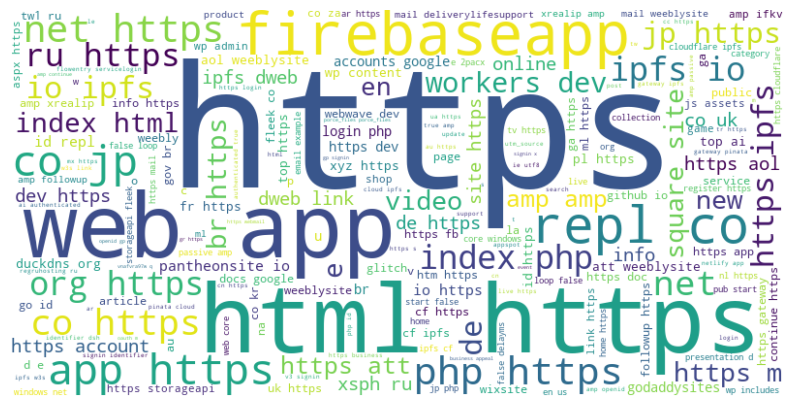

In [7]:
urls = " ".join(data['url'])

word_cloud = WordCloud(width=800,height=400,background_color='white').generate(urls)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
data = data.drop(['url'], axis=1)

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,190945.0,0.471340,0.499179,0.000000,0.000000,0.0,1.000000,1.000000
url_length,190945.0,45.773799,49.875336,13.000000,26.000000,34.0,50.000000,6097.000000
number_of_slashes,190945.0,3.336704,1.337578,2.000000,3.000000,3.0,4.000000,68.000000
is_https,190945.0,0.647055,0.477887,0.000000,0.000000,1.0,1.000000,1.000000
number_of_http_occurrences,190945.0,0.353479,0.479276,0.000000,0.000000,0.0,1.000000,7.000000
number_of_https_occurrences,190945.0,0.653261,0.485682,0.000000,0.000000,1.0,1.000000,17.000000
number_of_dots,190945.0,2.219660,1.173291,1.000000,2.000000,2.0,3.000000,134.000000
is_ip,190945.0,0.003137,0.055921,0.000000,0.000000,0.0,0.000000,1.000000
number_of_digits,190945.0,3.200304,12.924524,0.000000,0.000000,0.0,3.000000,1713.000000
number_of_dashes,190945.0,1.130284,3.065725,0.000000,0.000000,0.0,1.000000,286.000000


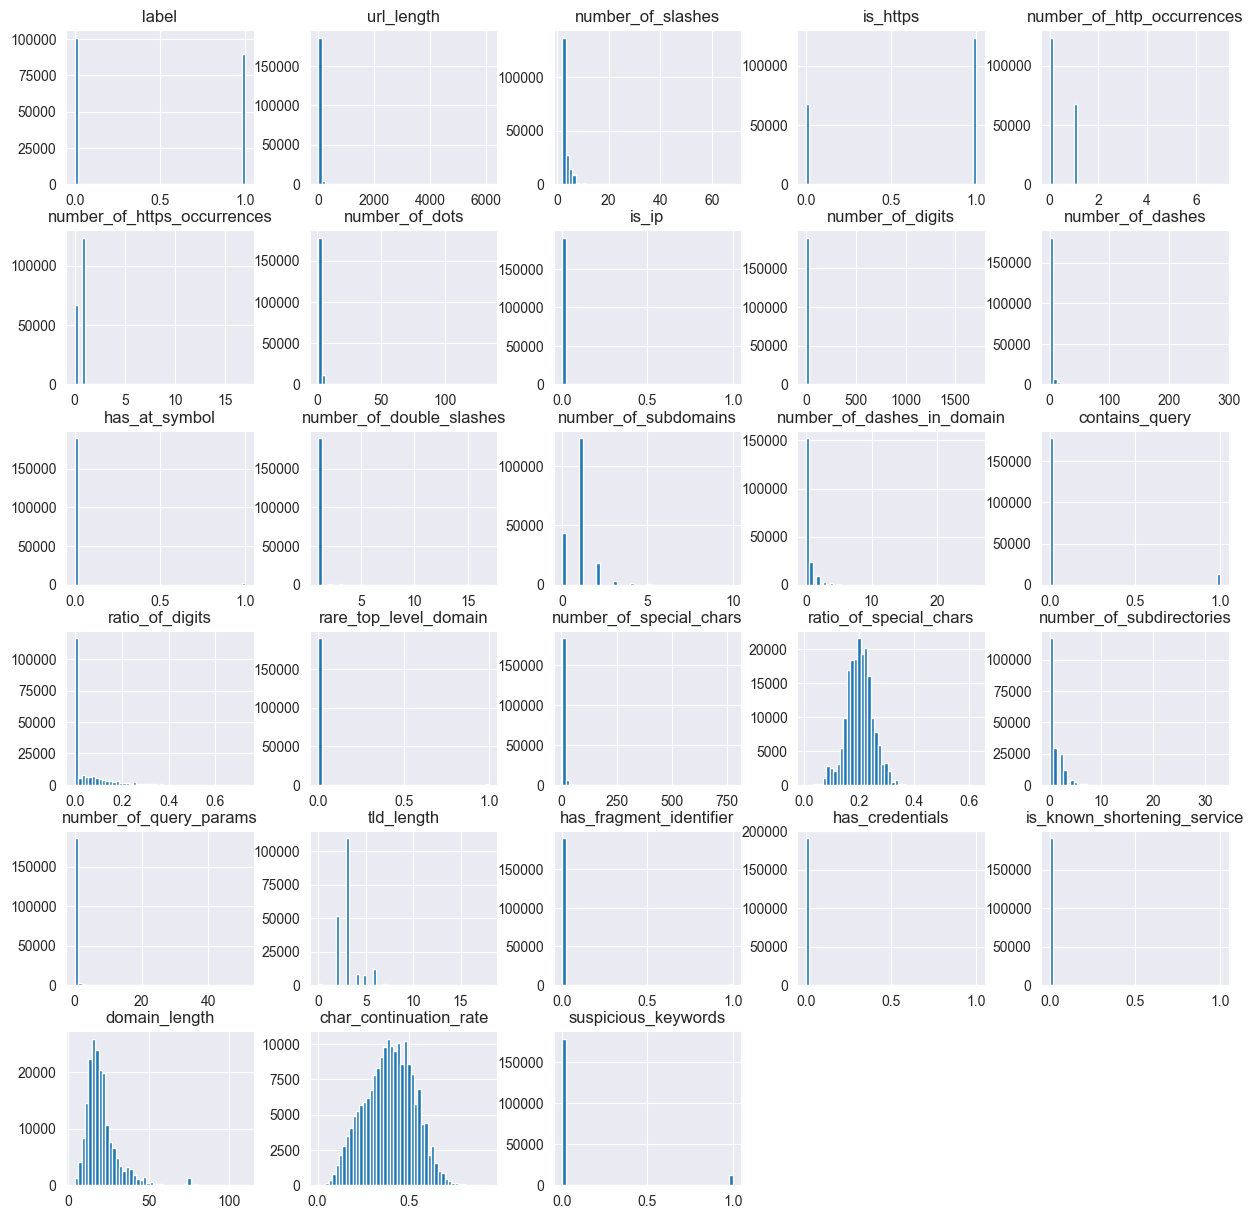

In [10]:
data.hist(bins=50, figsize=(15, 15))
plt.show()

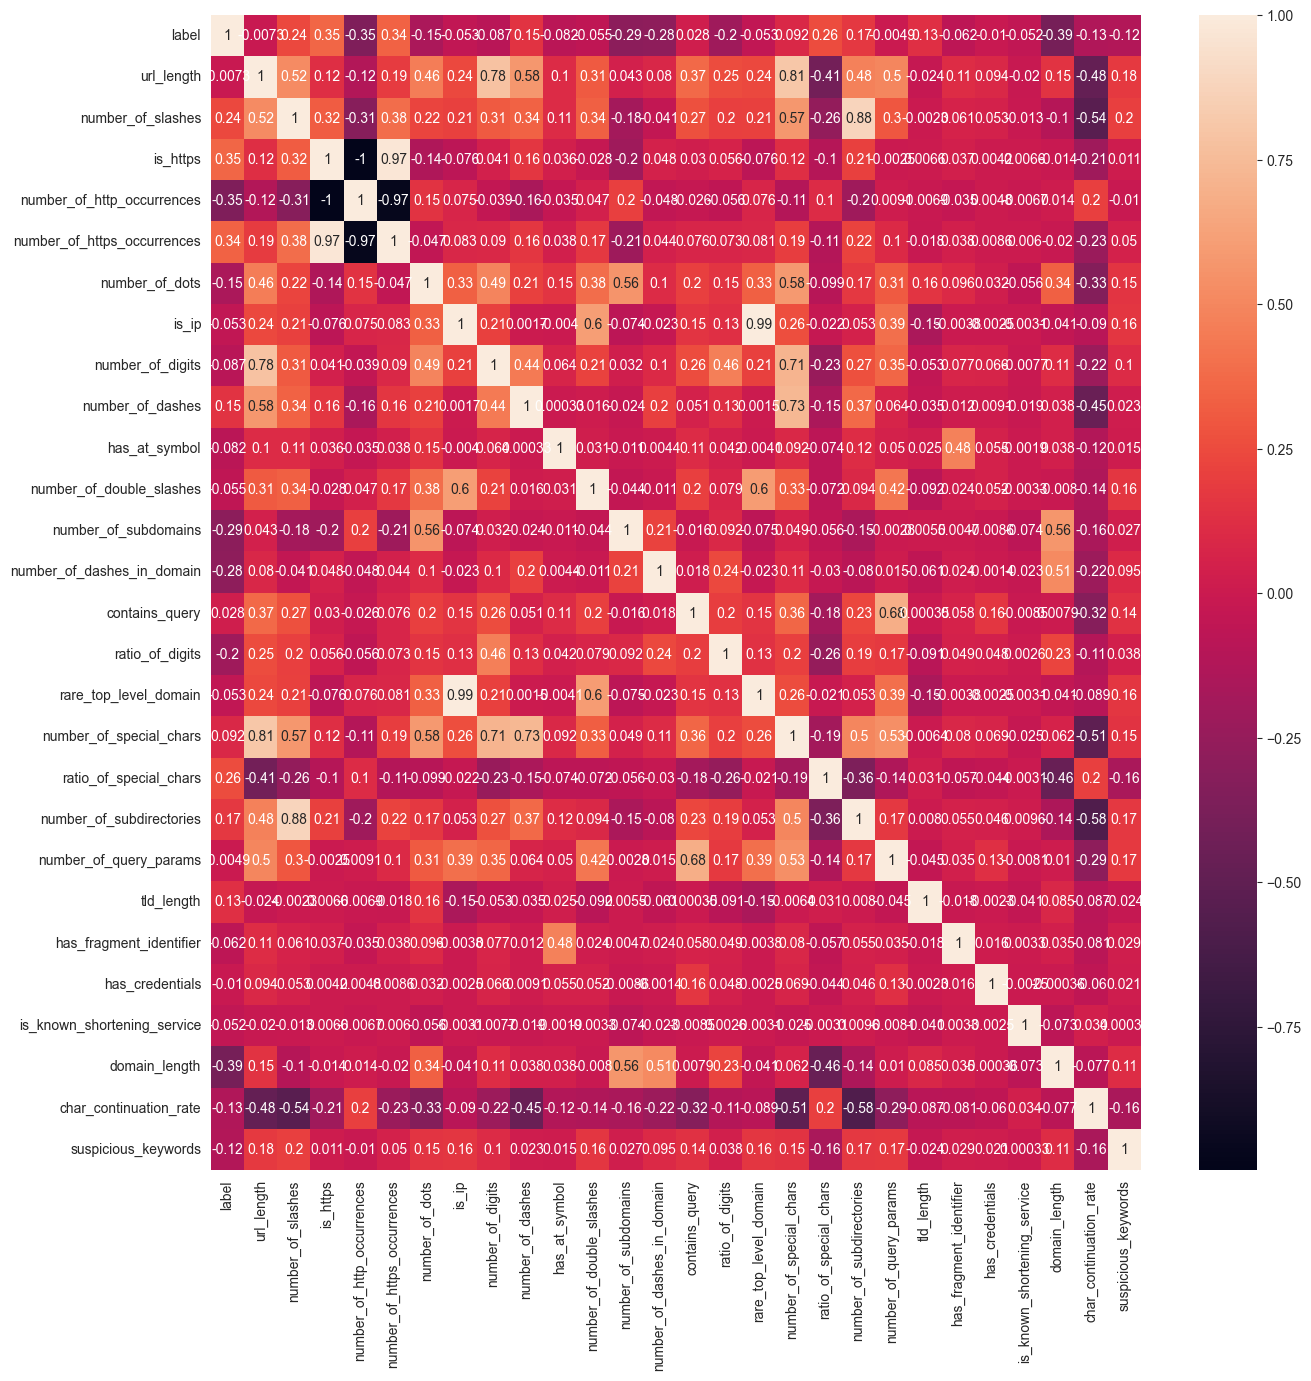

In [11]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

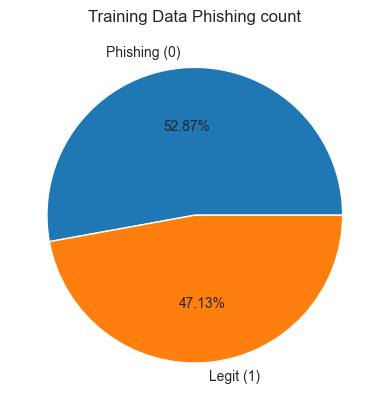

In [12]:
counts = data['label'].value_counts()
counts = counts.rename(index={0: 'Phishing (0)', 1: 'Legit (1)'})
counts.plot(kind='pie', autopct='%1.2f%%')
plt.title("Training Data Phishing count")
plt.ylabel('')
plt.show()

In [13]:
X = data.drop(['label'], axis=1)
y = data['label']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((152756, 27), (38189, 27), (152756,), (38189,))

#### Train Support Vector Classifier

In [15]:
pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC())])

param_dist = {
  "svc__kernel": ["rbf"],
  "svc__C": loguniform(1e-2, 1e2),
  "svc__gamma": loguniform(1e-4, 1e0),
  "svc__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(pipe, param_dist, cv=cv, scoring="f1", n_jobs=-1, n_iter=36)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=36, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12b6a1ca0>,
                                        'svc__class_weight': [None, 'balanced'],
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12b6d27c0>,
                                        'svc__kernel': ['rbf']},
                   scoring='f1')

In [16]:
y_train_svc = rs.predict(X_train)
y_test_svc = rs.predict(X_test)

# safe best model:
best_model_svc = rs.best_estimator_
joblib.dump(best_model_svc, '../models/ml/best_svc.pkl')
print(rs.best_params_)

{'svc__C': np.float64(10.498309187755854), 'svc__class_weight': None, 'svc__gamma': np.float64(0.17403132916181402), 'svc__kernel': 'rbf'}


In [17]:
acc_train_svc = metrics.accuracy_score(y_train,y_train_svc)
acc_test_svc = metrics.accuracy_score(y_test,y_test_svc)
print("Support Vector Machine : Accuracy on training Data: {:.4f}".format(acc_train_svc))
print("Support Vector Machine : Accuracy on test Data: {:.4f}".format(acc_test_svc))

Support Vector Machine : Accuracy on training Data: 0.9397
Support Vector Machine : Accuracy on test Data: 0.9286


In [18]:
print("Training Data:")
print(metrics.classification_report(y_train, y_train_svc, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9672    0.9171    0.9415     80756
    Legit(1)     0.9121    0.9651    0.9379     72000

    accuracy                         0.9397    152756
   macro avg     0.9397    0.9411    0.9397    152756
weighted avg     0.9413    0.9397    0.9398    152756



In [19]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_test_svc, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9535    0.9094    0.9309     20189
    Legit(1)     0.9034    0.9502    0.9262     18000

    accuracy                         0.9286     38189
   macro avg     0.9284    0.9298    0.9286     38189
weighted avg     0.9299    0.9286    0.9287     38189



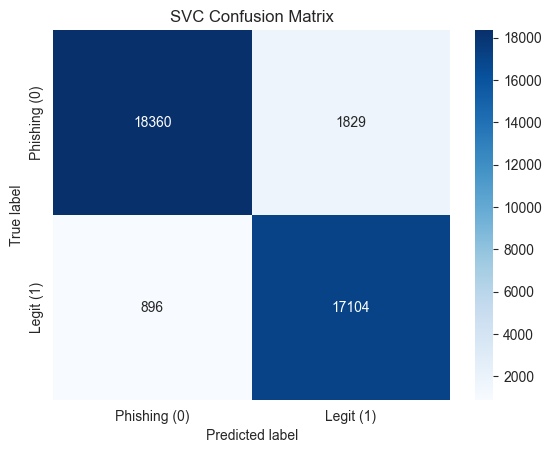

In [20]:
svm_conf_matrix = metrics.confusion_matrix(y_test, y_test_svc)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('SVC Confusion Matrix')
plt.show()

#### Train Random Forest Classifier

In [21]:
param_dist = {
    "criterion": ["gini"],
    "n_estimators": randint(300, 801),
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": randint(1, 21),
    "min_samples_split": randint(2, 41),
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42), param_distributions=param_dist, n_iter=36, cv=cv, scoring="f1")
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=36,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', 0.3,
                                                         0.5, 0.7],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12c48e3a0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12c0d45e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12c1d5cd0>},
                   scoring='f1')

In [22]:
y_train_forest = rs.predict(X_train)
y_test_forest = rs.predict(X_test)

best_model_rf = rs.best_estimator_
joblib.dump(best_model_rf, '../models/ml/best_rf.pkl')
print(rs.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 761}


In [23]:
acc_train_forest = metrics.accuracy_score(y_train,y_train_forest)
acc_test_forest = metrics.accuracy_score(y_test,y_test_forest)
print("Random Forest : Accuracy on training Data: {:.4f}".format(acc_train_forest))
print("Random Forest : Accuracy on test Data: {:.4f}".format(acc_test_forest))

Random Forest : Accuracy on training Data: 0.9518
Random Forest : Accuracy on test Data: 0.9312


In [24]:
print("Training Data:")
print(metrics.classification_report(y_train, y_train_forest, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9827    0.9252    0.9531     80756
    Legit(1)     0.9213    0.9817    0.9505     72000

    accuracy                         0.9518    152756
   macro avg     0.9520    0.9535    0.9518    152756
weighted avg     0.9537    0.9518    0.9519    152756



In [25]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_test_forest, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9616    0.9059    0.9329     20189
    Legit(1)     0.9009    0.9594    0.9293     18000

    accuracy                         0.9312     38189
   macro avg     0.9313    0.9327    0.9311     38189
weighted avg     0.9330    0.9312    0.9312     38189



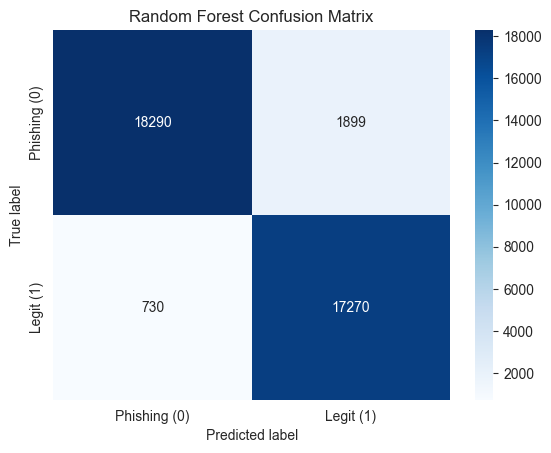

In [26]:
forest_conf_matrix = metrics.confusion_matrix(y_test, y_test_forest)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(forest_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Confusion Matrix')
plt.show()

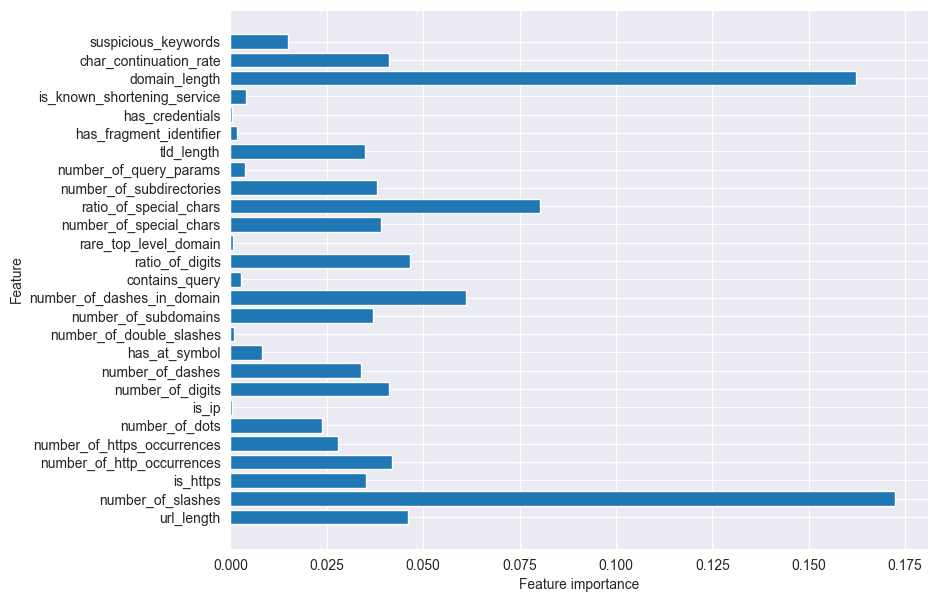

In [27]:
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), best_model_rf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

#### Train Decision Tree Classifier

In [28]:
param_dist = {
    "criterion": ["gini"],
    "splitter": ["best", "random"],
    "max_depth": [4, 6, 8, 12, 16],
    "min_samples_leaf": randint(1, 21),
    "min_samples_split": randint(2, 41),
    "max_features": ["sqrt", "log2", 0.5, 0.7],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                        param_dist, n_iter=36, cv=cv, scoring="f1", n_jobs=-1,
                        random_state=42)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42), n_iter=36,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [4, 6, 8, 12, 16],
                                        'max_features': ['sqrt', 'log2', 0.5,
                                                         0.7],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12ff434c0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12ddb6e80>,
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='f1')

In [29]:
y_test_tree = rs.predict(X_test)
y_train_tree = rs.predict(X_train)

# safe best model:
best_model_dt = rs.best_estimator_
joblib.dump(best_model_dt, '../models/ml/best_dt.pkl')
print(rs.best_params_)

{'criterion': 'gini', 'max_depth': 16, 'max_features': 0.7, 'min_samples_leaf': 17, 'min_samples_split': 28, 'splitter': 'best'}


In [30]:
acc_train_tree = accuracy_score(y_train,y_train_tree)
acc_test_tree = accuracy_score(y_test,y_test_tree)

print("Decision Tree : Accuracy on training Data: {:.4f}".format(acc_train_tree))
print("Decision Tree : Accuracy on test Data: {:.4f}".format(acc_test_tree))

Decision Tree : Accuracy on training Data: 0.9155
Decision Tree : Accuracy on test Data: 0.9083


In [31]:
print("Training Data:")
print(metrics.classification_report(y_train, y_train_tree, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9517    0.8850    0.9172     80756
    Legit(1)     0.8805    0.9497    0.9138     72000

    accuracy                         0.9155    152756
   macro avg     0.9161    0.9174    0.9155    152756
weighted avg     0.9181    0.9155    0.9156    152756



In [32]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_test_tree, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9422    0.8805    0.9103     20189
    Legit(1)     0.8752    0.9394    0.9061     18000

    accuracy                         0.9083     38189
   macro avg     0.9087    0.9100    0.9082     38189
weighted avg     0.9106    0.9083    0.9083     38189



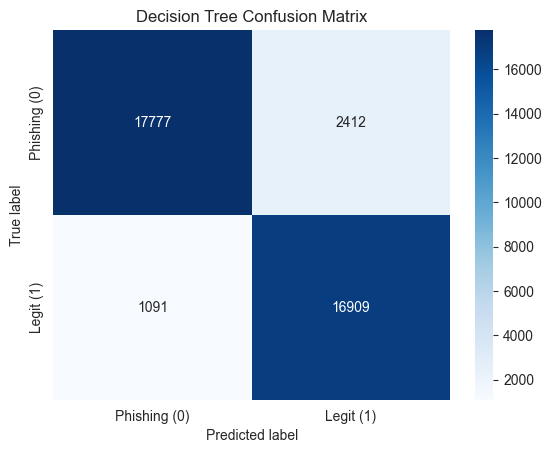

In [33]:
dt_conf_matrix = metrics.confusion_matrix(y_test, y_test_tree)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(dt_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Decision Tree Confusion Matrix')
plt.show()

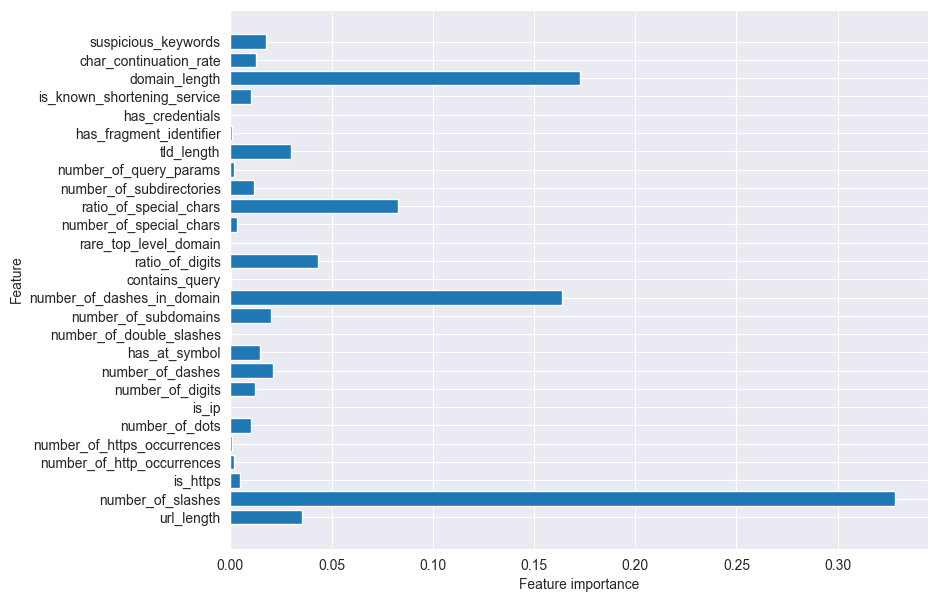

In [34]:
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), best_model_dt.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

#### Train XGBoost Classifier

In [35]:
param_dist = {
    "max_depth": randint(3, 9),
    "n_estimators": randint(200, 801),
    "learning_rate": loguniform(1e-2, 2e-1),
    "min_child_weight": loguniform(1e-1, 1e1),
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(XGBClassifier(random_state=42), param_dist, n_iter=36, cv=cv, scoring="f1",
                        n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12c1baaf0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12c1ba3a0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12fbc22e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12fbc26d0>,
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1')

In [36]:
y_test_xgb = rs.predict(X_test)
y_train_xgb = rs.predict(X_train)

# safe best model:
best_model_xgb = rs.best_estimator_
joblib.dump(best_model_xgb, '../models/ml/best_xgb.pkl')
print(rs.best_params_)

{'colsample_bytree': 0.6, 'learning_rate': np.float64(0.0868943933974746), 'max_depth': 8, 'min_child_weight': np.float64(0.9718319944817401), 'n_estimators': 592, 'subsample': 1.0}


In [37]:
acc_train_xgb = accuracy_score(y_train,y_train_xgb)
acc_test_xgb = accuracy_score(y_test,y_test_xgb)
print("XGBoost : Accuracy on training Data: {:.4f}".format(acc_train_xgb))
print("XGBoost : Accuracy on test Data: {:.4f}".format(acc_test_xgb))

XGBoost : Accuracy on training Data: 0.9502
XGBoost : Accuracy on test Data: 0.9331


In [38]:
print("Training Data:")
print(metrics.classification_report(y_train, y_train_xgb, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9740    0.9306    0.9518     80756
    Legit(1)     0.9258    0.9722    0.9484     72000

    accuracy                         0.9502    152756
   macro avg     0.9499    0.9514    0.9501    152756
weighted avg     0.9513    0.9502    0.9502    152756



In [39]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_test_xgb, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9576    0.9139    0.9352     20189
    Legit(1)     0.9081    0.9546    0.9308     18000

    accuracy                         0.9331     38189
   macro avg     0.9328    0.9342    0.9330     38189
weighted avg     0.9343    0.9331    0.9331     38189



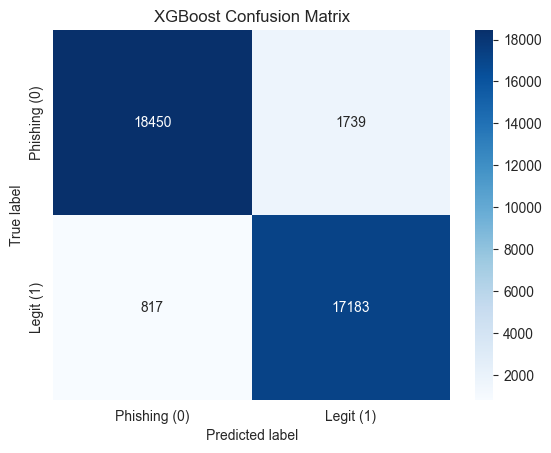

In [40]:
xgb_conf_matrix = metrics.confusion_matrix(y_test, y_test_xgb)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(xgb_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('XGBoost Confusion Matrix')
plt.show()

#### Train Logistic Regression

In [41]:
pipe = Pipeline([("scaler", StandardScaler()),
                 ("lr", LogisticRegression(solver="saga", max_iter=10000, random_state=42))])

param_dist = {
    "lr__C": loguniform(1e-3, 1e3),
    "lr__penalty": ["l1", "l2"],
    "lr__class_weight": [None, "balanced"],
}

rs = RandomizedSearchCV(pipe, param_dist, n_iter=36, cv=cv, scoring="f1", n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('lr',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42,
                                                                 solver='saga'))]),
                   n_iter=36, n_jobs=-1,
                   param_distributions={'lr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12fbb25b0>,
                                        'lr__class_weight': [None, 'balanced'],
                                        'lr__penalty': ['l1', 'l2']},
                   random_state=42, scoring='f1')

In [42]:
y_test_lr = rs.predict(X_test)
y_train_lr = rs.predict(X_train)

# safe best model:
best_model_lr = rs.best_estimator_
joblib.dump(best_model_lr, '../models/ml/best_lr.pkl')
print(rs.best_params_)

{'lr__C': np.float64(98.77700294007911), 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}


In [43]:
acc_train_lr = accuracy_score(y_train,y_train_lr)
acc_test_lr = accuracy_score(y_test,y_test_lr)
print("Logistic Regression : Accuracy on training Data: {:.4f}".format(acc_train_lr))
print("Logistic Regression : Accuracy on test Data: {:.4f}".format(acc_test_lr))

Logistic Regression : Accuracy on training Data: 0.8486
Logistic Regression : Accuracy on test Data: 0.8514


In [44]:
print("Training Data:")
print(metrics.classification_report(y_train, y_train_lr, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.8730    0.8352    0.8537     80756
    Legit(1)     0.8237    0.8638    0.8432     72000

    accuracy                         0.8486    152756
   macro avg     0.8484    0.8495    0.8485    152756
weighted avg     0.8498    0.8486    0.8488    152756



In [45]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_test_lr, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.8760    0.8374    0.8563     20189
    Legit(1)     0.8262    0.8671    0.8462     18000

    accuracy                         0.8514     38189
   macro avg     0.8511    0.8522    0.8512     38189
weighted avg     0.8526    0.8514    0.8515     38189



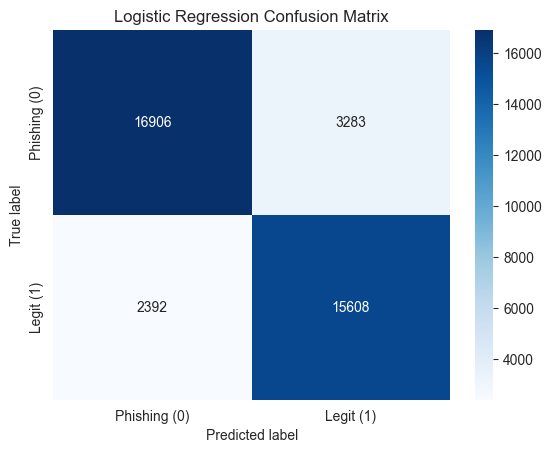

In [46]:
lr_conf_matrix = metrics.confusion_matrix(y_test, y_test_lr)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

#### Train K-Nearest-Neighbors Classifier

In [47]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_jobs=-1))
])

param_dist = {
    "knn__n_neighbors": np.arange(3, 51, 2),
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],                     # 1=Manhattan, 2=Euklidisch
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=36,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_iter=36, n_jobs=-1,
                   param_distributions={'knn__n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49]),
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   random_state=42, scoring='f1')

In [48]:
y_test_knn = rs.predict(X_test)
y_train_knn = rs.predict(X_train)

# safe best model:
best_model_knn = rs.best_estimator_
joblib.dump(best_model_knn, '../models/ml/best_knn.pkl')
print(rs.best_params_)

{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': np.int64(19)}


In [49]:
acc_train_knn = accuracy_score(y_train,y_train_knn)
acc_test_knn = accuracy_score(y_test,y_test_knn)
print("KNN : Accuracy on training Data: {:.4f}".format(acc_train_knn))
print("KNN : Accuracy on test Data: {:.4f}".format(acc_test_knn))

KNN : Accuracy on training Data: 0.9699
KNN : Accuracy on test Data: 0.9296


In [50]:
print("Training Data:")
print(metrics.classification_report(y_train, y_train_knn, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9818    0.9608    0.9712     80756
    Legit(1)     0.9571    0.9800    0.9684     72000

    accuracy                         0.9699    152756
   macro avg     0.9694    0.9704    0.9698    152756
weighted avg     0.9702    0.9699    0.9699    152756



In [51]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_test_knn, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9499    0.9151    0.9322     20189
    Legit(1)     0.9085    0.9459    0.9268     18000

    accuracy                         0.9296     38189
   macro avg     0.9292    0.9305    0.9295     38189
weighted avg     0.9304    0.9296    0.9296     38189



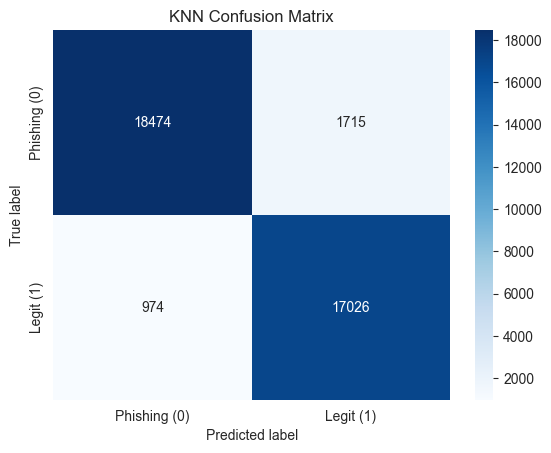

In [52]:
knn_conf_matrix = metrics.confusion_matrix(y_test, y_test_knn)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(knn_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('KNN Confusion Matrix')
plt.show()

#### Train Naive Bayes

In [53]:
nb = GaussianNB()

param_dist = {
    "var_smoothing": loguniform(1e-11, 1e-7),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(
    nb, param_distributions=param_dist, n_iter=36,
    cv=cv, scoring="f1", n_jobs=-1, random_state=42
)
rs.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=GaussianNB(), n_iter=36, n_jobs=-1,
                   param_distributions={'var_smoothing': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12f9b2940>},
                   random_state=42, scoring='f1')

In [54]:
y_test_nb = rs.predict(X_test)
y_train_nb = rs.predict(X_train)

# safe best model:
best_model_nb = rs.best_estimator_
joblib.dump(best_model_nb, '../models/ml/best_nb.pkl')
print(rs.best_params_)

{'var_smoothing': np.float64(7.579479953347982e-08)}


In [55]:
acc_train_nb = accuracy_score(y_train,y_train_nb)
acc_test_nb = accuracy_score(y_test,y_test_nb)

print("Naive Bayes : Accuracy on training Data: {:.4f}".format(acc_train_nb))
print("Naive Bayes : Accuracy on test Data: {:.4f}".format(acc_test_nb))

Naive Bayes : Accuracy on training Data: 0.6058
Naive Bayes : Accuracy on test Data: 0.6020


In [56]:
print("Training Data:")
print(metrics.classification_report(y_train, y_train_nb, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Training Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9433    0.2707    0.4206     80756
    Legit(1)     0.5455    0.9817    0.7013     72000

    accuracy                         0.6058    152756
   macro avg     0.7444    0.6262    0.5610    152756
weighted avg     0.7558    0.6058    0.5529    152756



In [57]:
print("Testing Data:")
print(metrics.classification_report(y_test, y_test_nb, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

Testing Data:
              precision    recall  f1-score   support

 Phishing(0)     0.9371    0.2648    0.4130     20189
    Legit(1)     0.5431    0.9801    0.6989     18000

    accuracy                         0.6020     38189
   macro avg     0.7401    0.6225    0.5559     38189
weighted avg     0.7514    0.6020    0.5477     38189



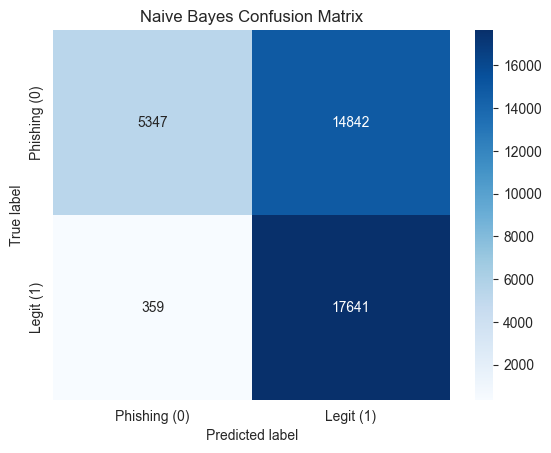

In [58]:
nb_conf_matrix = metrics.confusion_matrix(y_test, y_test_nb)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(nb_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

#### ROC Training Curves

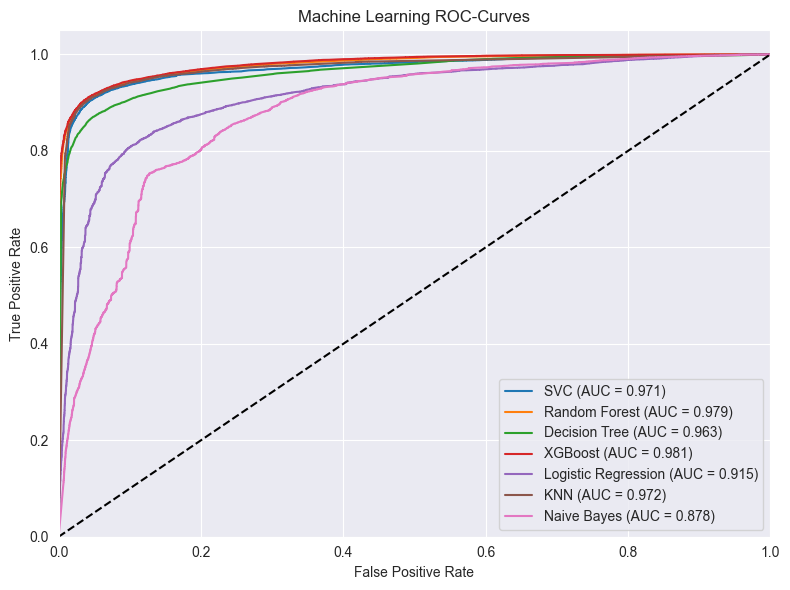

In [59]:
models = {
    "SVC": best_model_svc,
    "Random Forest": best_model_rf,
    "Decision Tree": best_model_dt,
    "XGBoost": best_model_xgb,
    "Logistic Regression": best_model_lr,
    "KNN": best_model_knn,
    "Naive Bayes": best_model_nb,
}

def get_scores(model, X, positive_class):
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        classes = model.classes_
        pos_idx = np.where(classes == positive_class)[0][0]
        return proba[:, pos_idx]

    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        classes = model.classes_

        if scores.ndim > 1:
            pos_idx = np.where(classes == positive_class)[0][0]
            return scores[:, pos_idx]

        if len(classes) == 2:
            cls0, cls1 = classes
            if positive_class == cls1:
                return scores
            else:
                return -scores
        else:
            return scores
    else:
        raise ValueError()

plt.figure(figsize=(8, 6))

y_true_phishing = (y_test == 0).astype(int)

for name, model in models.items():
    y_score = get_scores(model, X_test, positive_class=0)
    fpr, tpr, _ = roc_curve(y_true_phishing, y_score)
    auc = roc_auc_score(y_true_phishing, y_score)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Machine Learning ROC-Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluation

#### Load and visualize Evaluation Data

In [60]:
eval_data = pd.read_csv("../data/evaluation/evaluation-features.csv")
eval_data.head()

,url,label,url_length,number_of_slashes,is_https,number_of_http_occurrences,number_of_https_occurrences,number_of_dots,is_ip,number_of_digits,...,ratio_of_special_chars,number_of_subdirectories,number_of_query_params,tld_length,has_fragment_identifier,has_credentials,is_known_shortening_service,domain_length,char_continuation_rate,suspicious_keywords
0,http://4aoo-bmmanager045288.vercel.app/?naps,0,44,3,0,1,0,2,0,7,...,0.181818,0,1,3,0,0,0,31,0.409091,0
1,http://0suz-bmmanager047181.vercel.app/?naps,0,44,3,0,1,0,2,0,7,...,0.181818,0,1,3,0,0,0,31,0.409091,0
2,http://ncrm-casefb588197.vercel.app/?naps,0,41,3,0,1,0,2,0,6,...,0.195122,0,1,3,0,0,0,28,0.365854,0
3,http://casefb668303-f2w6.vercel.app/?naps,0,41,3,0,1,0,2,0,8,...,0.195122,0,1,3,0,0,0,28,0.365854,0
4,http://casefb480777-qhn9.vercel.app/?naps,0,41,3,0,1,0,2,0,7,...,0.195122,0,1,3,0,0,0,28,0.365854,0


In [61]:
eval_data.columns

Index(['url', 'label', 'url_length', 'number_of_slashes', 'is_https',
       'number_of_http_occurrences', 'number_of_https_occurrences',
       'number_of_dots', 'is_ip', 'number_of_digits', 'number_of_dashes',
       'has_at_symbol', 'number_of_double_slashes', 'number_of_subdomains',
       'number_of_dashes_in_domain', 'contains_query', 'ratio_of_digits',
       'rare_top_level_domain', 'number_of_special_chars',
       'ratio_of_special_chars', 'number_of_subdirectories',
       'number_of_query_params', 'tld_length', 'has_fragment_identifier',
       'has_credentials', 'is_known_shortening_service', 'domain_length',
       'char_continuation_rate', 'suspicious_keywords'],
      dtype='object')

In [62]:
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54270 entries, 0 to 54269
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   url                          54270 non-null  object 
 1   label                        54270 non-null  int64  
 2   url_length                   54270 non-null  int64  
 3   number_of_slashes            54270 non-null  int64  
 4   is_https                     54270 non-null  int64  
 5   number_of_http_occurrences   54270 non-null  int64  
 6   number_of_https_occurrences  54270 non-null  int64  
 7   number_of_dots               54270 non-null  int64  
 8   is_ip                        54270 non-null  int64  
 9   number_of_digits             54270 non-null  int64  
 10  number_of_dashes             54270 non-null  int64  
 11  has_at_symbol                54270 non-null  int64  
 12  number_of_double_slashes     54270 non-null  int64  
 13  number_of_subdom

In [63]:
eval_data.nunique()

url                            54270
label                              2
url_length                       332
number_of_slashes                 14
is_https                           2
number_of_http_occurrences         3
number_of_https_occurrences        4
number_of_dots                    28
is_ip                              1
number_of_digits                 128
number_of_dashes                  42
has_at_symbol                      2
number_of_double_slashes           3
number_of_subdomains              23
number_of_dashes_in_domain        12
contains_query                     2
ratio_of_digits                 2255
rare_top_level_domain              1
number_of_special_chars           69
ratio_of_special_chars          1399
number_of_subdirectories          12
number_of_query_params            23
tld_length                        12
has_fragment_identifier            2
has_credentials                    2
is_known_shortening_service        2
domain_length                    110
c

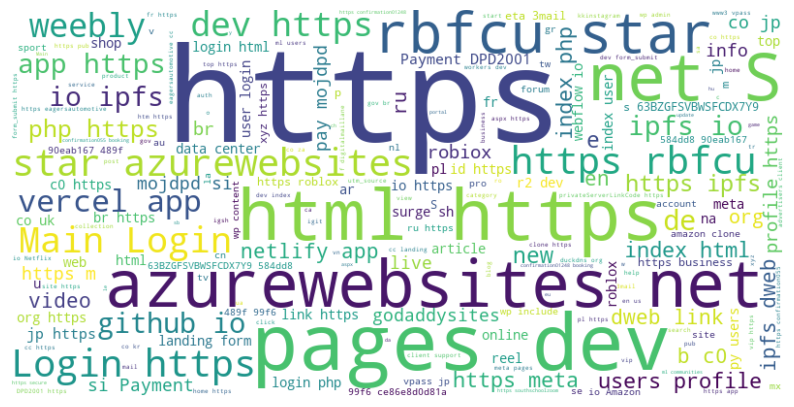

In [64]:
urls = " ".join(eval_data['url'])

word_cloud = WordCloud(width=800,height=400,background_color='white').generate(urls)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [65]:
eval_data = eval_data.drop(['url'], axis=1)

In [66]:
eval_data.describe().T

,count,mean,std,min,25%,50%,75%,max
label,54270.0,0.494398,0.499973,0.000000,0.000000,0.000000,1.000000,1.000000
url_length,54270.0,49.660807,43.857275,13.000000,28.000000,40.000000,59.000000,2736.000000
number_of_slashes,54270.0,3.745882,1.124347,3.000000,3.000000,3.000000,4.000000,24.000000
is_https,54270.0,0.682587,0.465474,0.000000,0.000000,1.000000,1.000000,1.000000
number_of_http_occurrences,54270.0,0.317542,0.465683,0.000000,0.000000,0.000000,1.000000,2.000000
number_of_https_occurrences,54270.0,0.682827,0.465894,0.000000,0.000000,1.000000,1.000000,3.000000
number_of_dots,54270.0,2.106099,1.088106,1.000000,2.000000,2.000000,2.000000,76.000000
is_ip,54270.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
number_of_digits,54270.0,3.744555,9.704541,0.000000,0.000000,0.000000,5.000000,480.000000
number_of_dashes,54270.0,1.346287,2.941772,0.000000,0.000000,0.000000,1.000000,68.000000


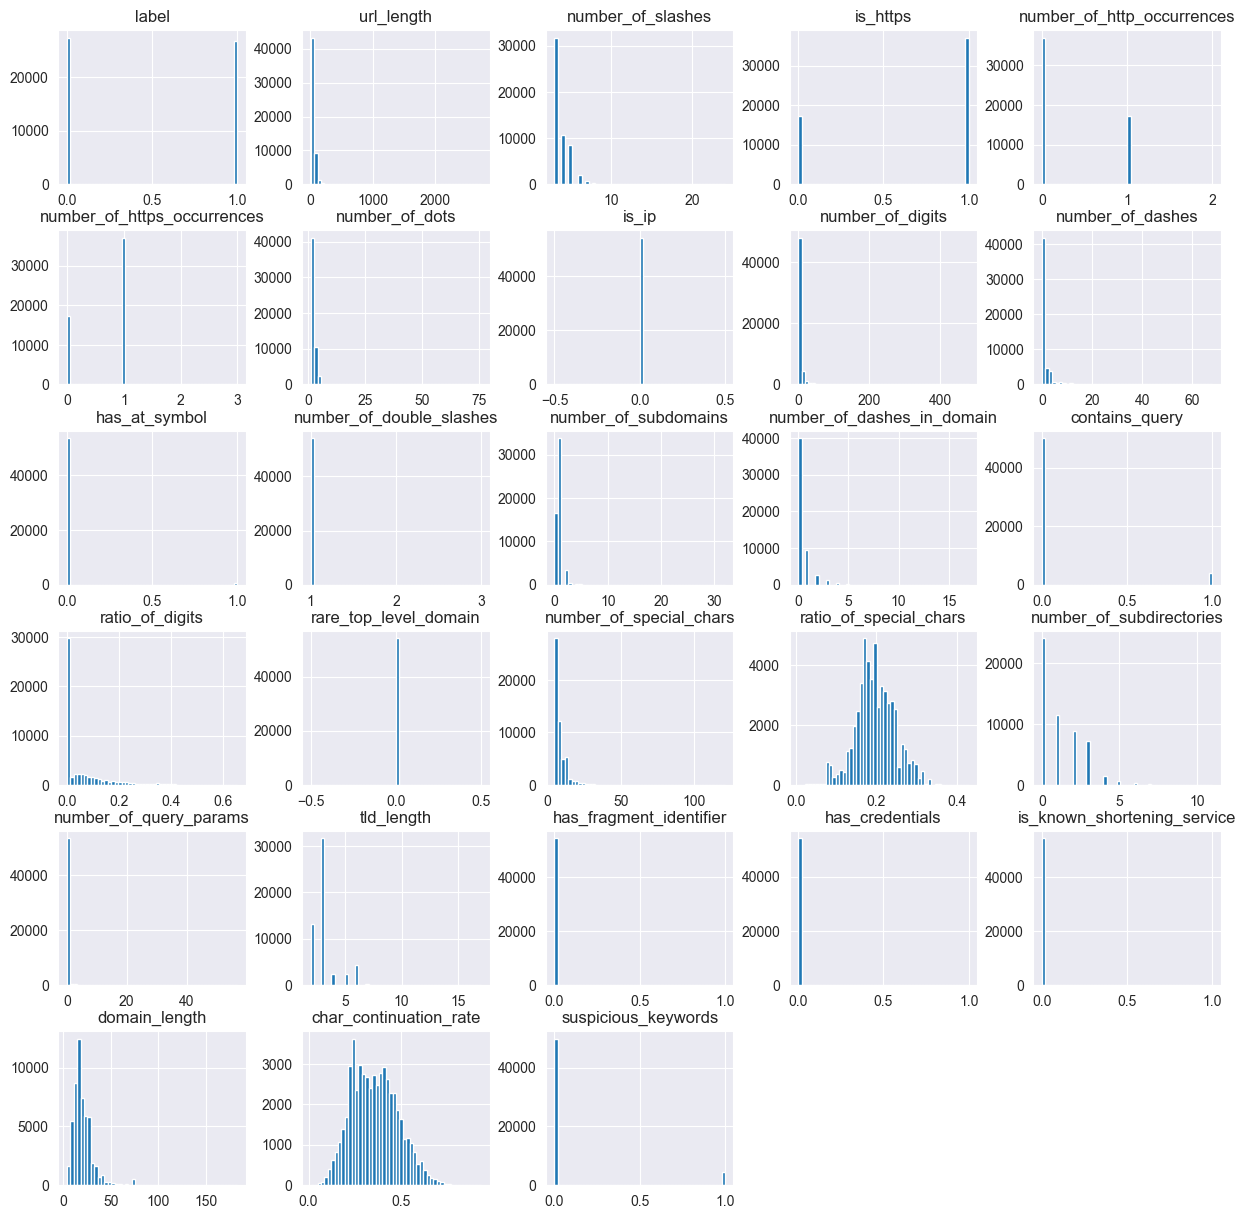

In [67]:
eval_data.hist(bins=50, figsize=(15, 15))
plt.show()

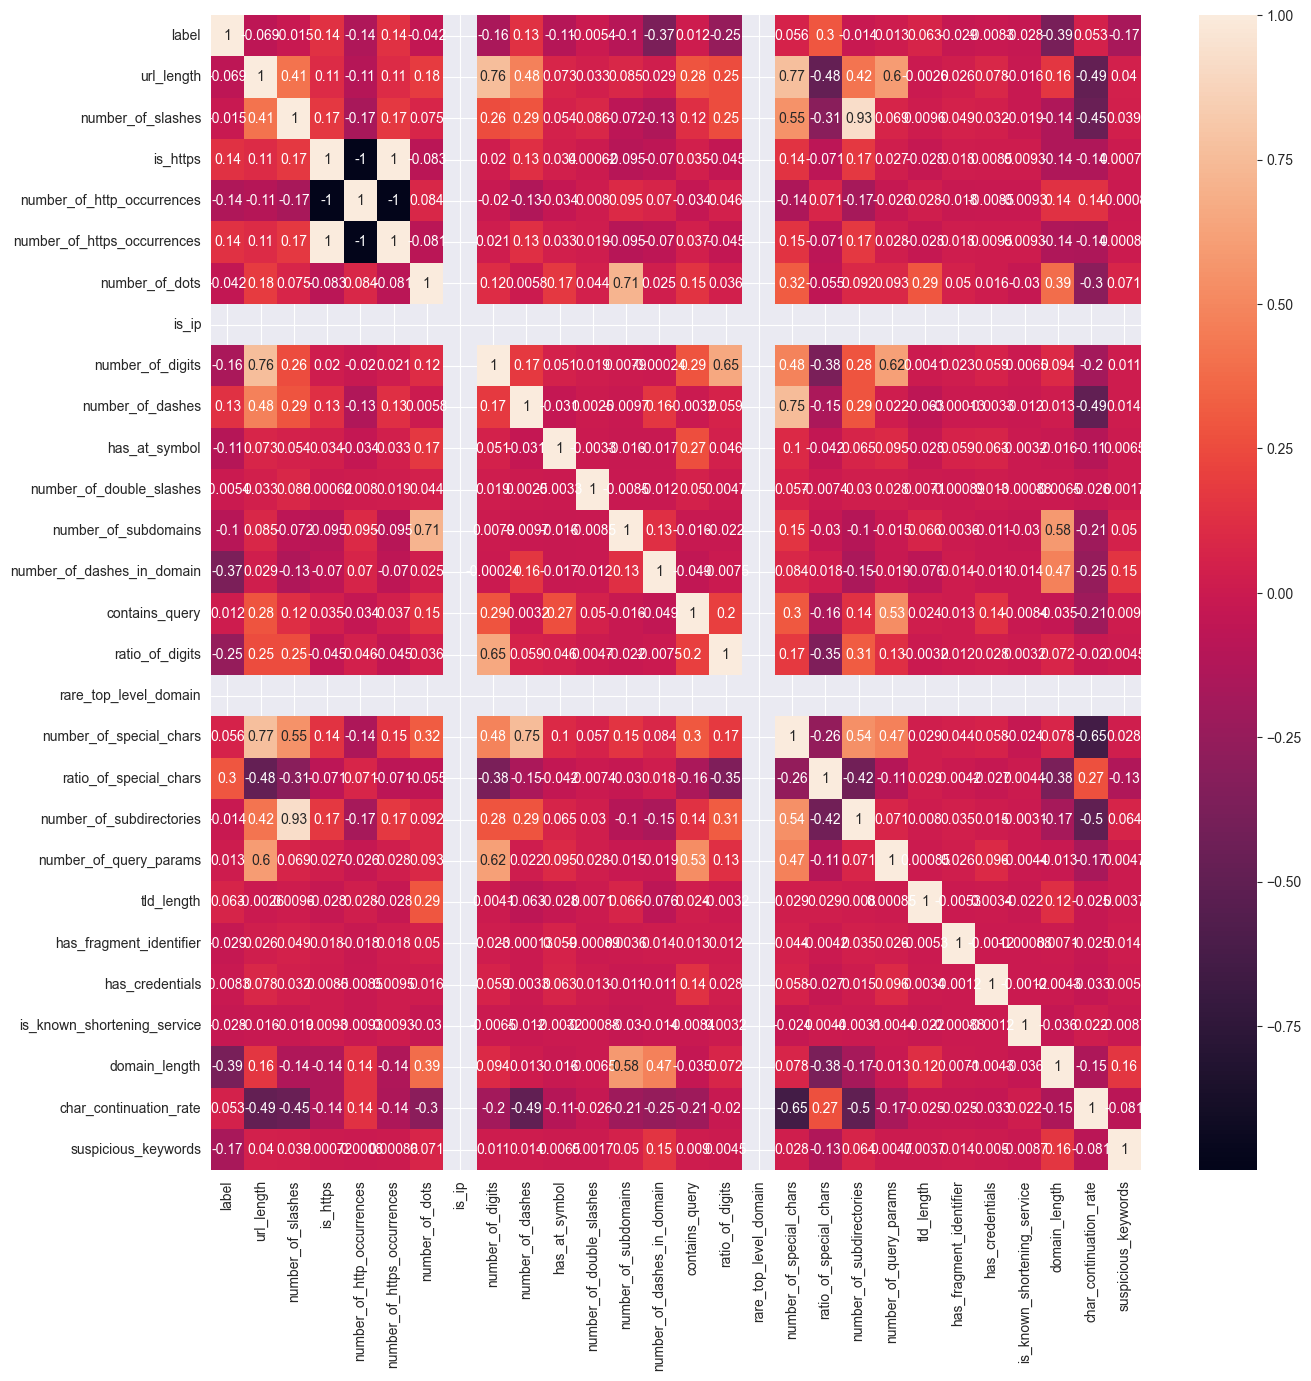

In [68]:
plt.figure(figsize=(15,15))
sns.heatmap(eval_data.corr(), annot=True)
plt.show()

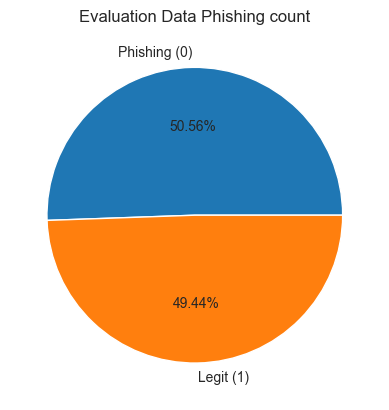

In [69]:
counts = eval_data['label'].value_counts()
counts = counts.rename(index={0: 'Phishing (0)', 1: 'Legit (1)'})
counts.plot(kind='pie', autopct='%1.2f%%')
plt.title("Evaluation Data Phishing count")
plt.ylabel('')
plt.show()

In [101]:
X_eval = eval_data.drop(['label'], axis=1)
y_eval = eval_data['label']

#### Evaluate Support Vector Classifier

In [71]:
y_eval_svc = best_model_svc.predict(X_eval)

In [72]:
acc_eval_svc = metrics.accuracy_score(y_eval,y_eval_svc)
print("Support Vector Machine : Accuracy on evaluation Data: {:.4f}".format(acc_eval_svc))

Support Vector Machine : Accuracy on evaluation Data: 0.7660


In [73]:
print(metrics.classification_report(y_eval, y_eval_svc, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.9305    0.5805    0.7149     27439
    Legit(1)     0.6902    0.9557    0.8015     26831

    accuracy                         0.7660     54270
   macro avg     0.8103    0.7681    0.7582     54270
weighted avg     0.8117    0.7660    0.7577     54270



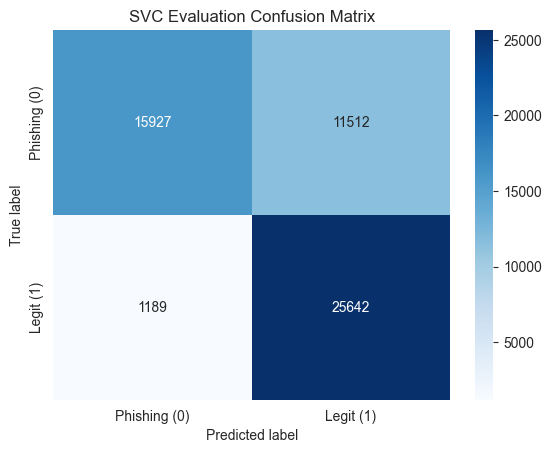

In [74]:
svm_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_eval_svc)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(svm_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('SVC Evaluation Confusion Matrix')
plt.show()

#### Evaluate Random Forest Classifier

In [75]:
y_eval_rf = best_model_rf.predict(X_eval)

In [76]:
acc_eval_rf = metrics.accuracy_score(y_eval,y_eval_rf)
print("Random Forest : Accuracy on evaluation Data: {:.4f}".format(acc_eval_rf))

Random Forest : Accuracy on evaluation Data: 0.7753


In [77]:
print(metrics.classification_report(y_eval, y_eval_rf, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.9504    0.5862    0.7251     27439
    Legit(1)     0.6960    0.9687    0.8100     26831

    accuracy                         0.7753     54270
   macro avg     0.8232    0.7774    0.7675     54270
weighted avg     0.8246    0.7753    0.7671     54270



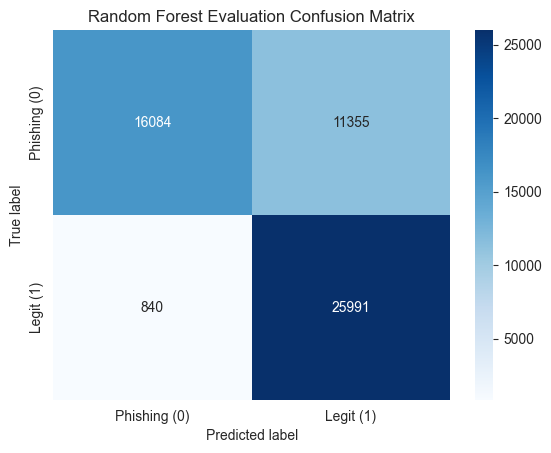

In [78]:
rf_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_eval_rf)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(rf_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest Evaluation Confusion Matrix')
plt.show()

#### Evaluate Decision Tree Classifier

In [79]:
y_eval_dt = best_model_dt.predict(X_eval)

In [80]:
acc_eval_dt = metrics.accuracy_score(y_eval,y_eval_dt)
print("Decision Tree : Accuracy on evaluation Data: {:.4f}".format(acc_eval_dt))

Decision Tree : Accuracy on evaluation Data: 0.7830


In [81]:
print(metrics.classification_report(y_eval, y_eval_dt, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.9149    0.6293    0.7457     27439
    Legit(1)     0.7126    0.9402    0.8107     26831

    accuracy                         0.7830     54270
   macro avg     0.8138    0.7847    0.7782     54270
weighted avg     0.8149    0.7830    0.7778     54270



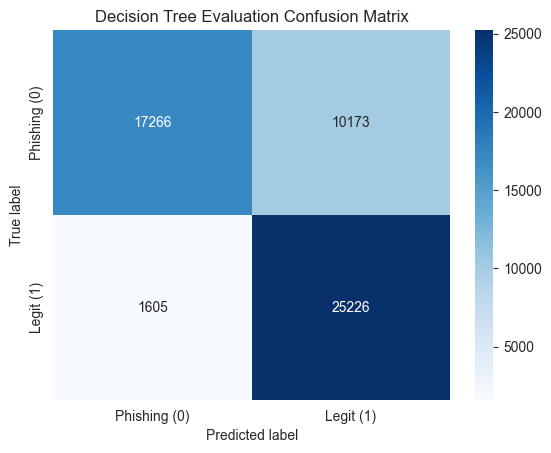

In [82]:
dt_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_eval_dt)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(dt_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Decision Tree Evaluation Confusion Matrix')
plt.show()

#### Evaluate XGBoost Classifier

In [83]:
y_eval_xgb = best_model_xgb.predict(X_eval)

In [84]:
acc_eval_xgb = metrics.accuracy_score(y_eval,y_eval_xgb)
print("XGBoost : Accuracy on evaluation Data: {:.4f}".format(acc_eval_xgb))

XGBoost : Accuracy on evaluation Data: 0.7704


In [85]:
print(metrics.classification_report(y_eval, y_eval_xgb, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.9385    0.5841    0.7200     27439
    Legit(1)     0.6931    0.9609    0.8053     26831

    accuracy                         0.7704     54270
   macro avg     0.8158    0.7725    0.7627     54270
weighted avg     0.8172    0.7704    0.7622     54270



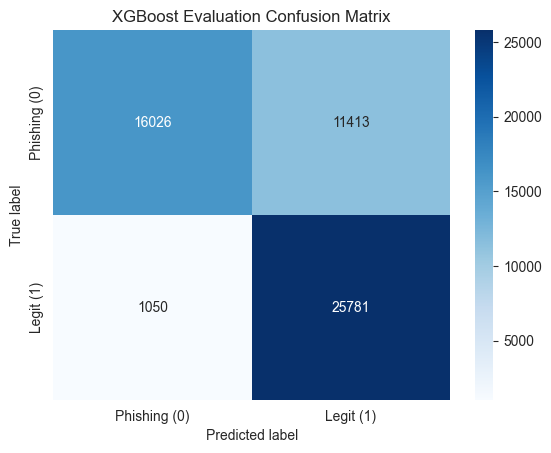

In [86]:
xgb_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_eval_xgb)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(xgb_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('XGBoost Evaluation Confusion Matrix')
plt.show()

#### Evaluate Logistic Regression

In [87]:
y_eval_lr = best_model_lr.predict(X_eval)

In [88]:
acc_eval_lr = metrics.accuracy_score(y_eval,y_eval_lr)
print("Logistic Regression : Accuracy on evaluation Data: {:.4f}".format(acc_eval_lr))

Logistic Regression : Accuracy on evaluation Data: 0.7577


In [89]:
print(metrics.classification_report(y_eval, y_eval_lr, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.8040    0.6886    0.7419     27439
    Legit(1)     0.7223    0.8283    0.7717     26831

    accuracy                         0.7577     54270
   macro avg     0.7632    0.7585    0.7568     54270
weighted avg     0.7636    0.7577    0.7566     54270



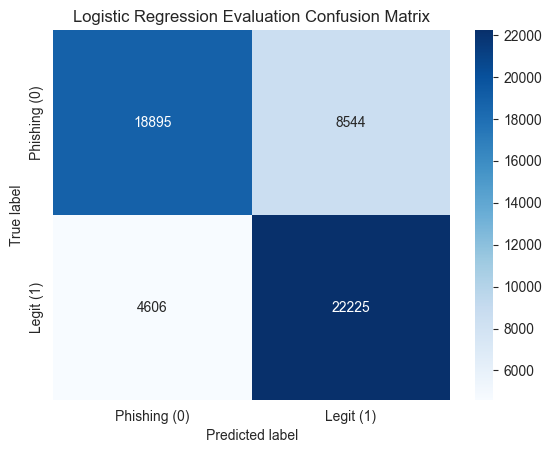

In [90]:
lr_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_eval_lr)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(lr_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Logistic Regression Evaluation Confusion Matrix')
plt.show()

#### Evaluate K-Nearest-Neighbors Classifier

In [91]:
y_eval_knn = best_model_knn.predict(X_eval)

In [92]:
acc_eval_knn = metrics.accuracy_score(y_eval,y_eval_knn)
print("KNN : Accuracy on evaluation Data: {:.4f}".format(acc_eval_knn))

KNN : Accuracy on evaluation Data: 0.7705


In [93]:
print(metrics.classification_report(y_eval, y_eval_knn, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.9390    0.5840    0.7201     27439
    Legit(1)     0.6932    0.9612    0.8055     26831

    accuracy                         0.7705     54270
   macro avg     0.8161    0.7726    0.7628     54270
weighted avg     0.8175    0.7705    0.7623     54270



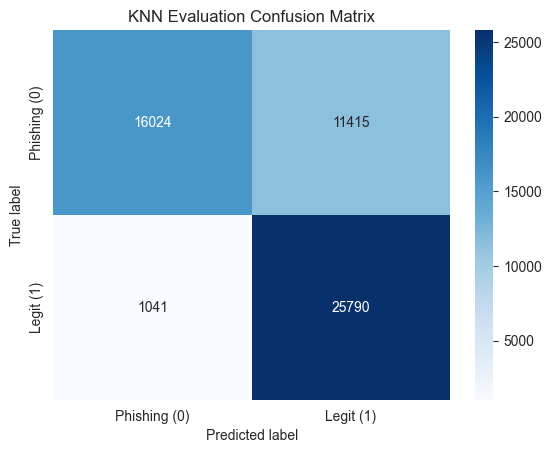

In [94]:
knn_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_eval_knn)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(knn_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('KNN Evaluation Confusion Matrix')
plt.show()

#### Evaluate Naive Bayes

In [95]:
y_eval_nb = best_model_nb.predict(X_eval)

In [96]:
acc_eval_nb = metrics.accuracy_score(y_eval,y_eval_nb)
print("Naive Bayes : Accuracy on evaluation Data: {:.4f}".format(acc_eval_nb))

Naive Bayes : Accuracy on evaluation Data: 0.6436


In [97]:
print(metrics.classification_report(y_eval, y_eval_nb, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.9410    0.3148    0.4717     27439
    Legit(1)     0.5830    0.9798    0.7310     26831

    accuracy                         0.6436     54270
   macro avg     0.7620    0.6473    0.6014     54270
weighted avg     0.7640    0.6436    0.5999     54270



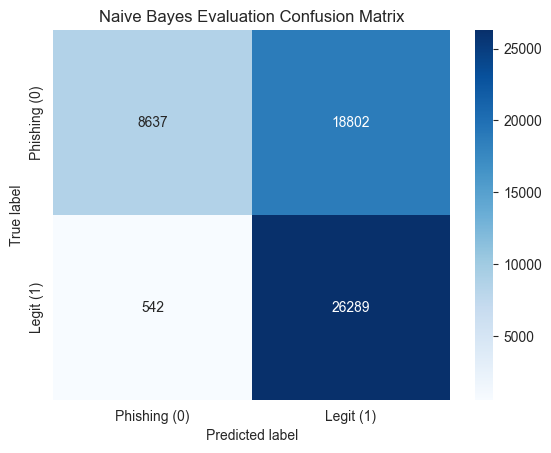

In [98]:
nb_eval_conf_matrix = metrics.confusion_matrix(y_eval, y_eval_nb)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(nb_eval_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Naive Bayes Evaluation Confusion Matrix')
plt.show()

#### ROC Evaluation Curves

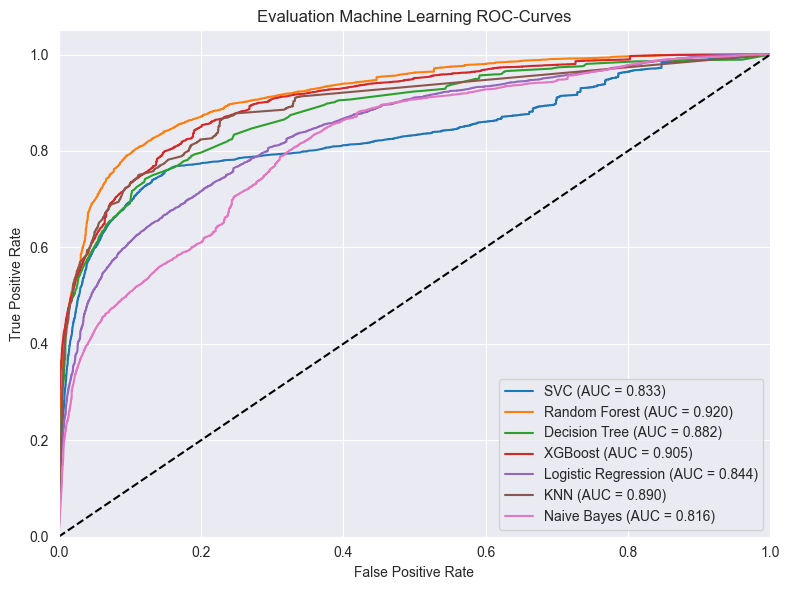

In [99]:
models = {
    "SVC": best_model_svc,
    "Random Forest": best_model_rf,
    "Decision Tree": best_model_dt,
    "XGBoost": best_model_xgb,
    "Logistic Regression": best_model_lr,
    "KNN": best_model_knn,
    "Naive Bayes": best_model_nb,
}

def get_scores(model, X, positive_class):
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        classes = model.classes_
        pos_idx = np.where(classes == positive_class)[0][0]
        return proba[:, pos_idx]

    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X)
        classes = model.classes_

        if scores.ndim > 1:
            pos_idx = np.where(classes == positive_class)[0][0]
            return scores[:, pos_idx]

        if len(classes) == 2:
            cls0, cls1 = classes
            if positive_class == cls1:
                return scores
            else:
                return -scores
        else:
            return scores
    else:
        raise ValueError()

plt.figure(figsize=(8, 6))

y_true_phishing = (y_eval == 0).astype(int)

for name, model in models.items():
    y_score = get_scores(model, X_eval, positive_class=0)
    fpr, tpr, _ = roc_curve(y_true_phishing, y_score)
    auc = roc_auc_score(y_true_phishing, y_score)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Evaluation Machine Learning ROC-Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()